In [1]:
!pip install -U datasets transformers[torch] evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 70.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 81.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.3
    Uninstalling transformers-4.39.3:
      Successfully uninstalled transformers-4.39.3
  Attempting uninstall: datasets
    Found existing installation: datasets 2.18.0
    Uninstalling datasets-2.18.0:
      Successfully uninstalled datasets-2.18.0


# Loading the dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("MrbBakh/Sentiment140")

Generating train split:   0%|          | 0/40000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

# Text Pre-processing

In [3]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def tokenize(row):
  tokens = word_tokenize(row['text'])
  # to lowercase and remove punctuation
  tokens = [token.lower() for token in tokens if token.isalpha()]
  return {
    'tokens': tokens
  }

dataset = dataset.map(tokenize)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [4]:
from nltk.corpus import stopwords

nltk.download('stopwords')

def remove_stopwords(row):
  stop_words = set(stopwords.words('english'))
  tokens = [token for token in row['tokens'] if token not in stop_words]
  return {
    'tokens': tokens
  }

dataset = dataset.map(remove_stopwords)

Parameter 'function'=<function remove_stopwords at 0x7ca9afcc8280> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

# Task 1

Use PorterStemmer from NLTK to stem the tokens.

In [5]:
from nltk.stem import PorterStemmer

def stem_tokens(row):
  stemmer = PorterStemmer()
  tokens = [stemmer.stem(token) for token in row['tokens']]
  return {
    'tokens': tokens
  }

dataset = dataset.map(stem_tokens)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

# Word Embedding

In [6]:
from gensim.models import Word2Vec

word_embedding = Word2Vec(dataset['train']['tokens'], vector_size=100,min_count=1, window=5, sg=1, hs=0, negative=10)

In [7]:
word_embedding.save('w2v.model')
word_embedding = Word2Vec.load('w2v.model')

# Average Vector

In [8]:
def vectorize(example):
  return {
    'vectors': [token for token in example['tokens'] if token in word_embedding.wv]
  }

def reduce_vectors(example):
  return {
    'mean': word_embedding.wv[example['vectors']].mean(axis=0)
  }

dataset = dataset.map(vectorize) \
  .filter(lambda e: len(e['vectors']) > 0) \
  .map(reduce_vectors)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/40000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/39908 [00:00<?, ? examples/s]

Map:   0%|          | 0/4956 [00:00<?, ? examples/s]

Map:   0%|          | 0/4963 [00:00<?, ? examples/s]

In [9]:
import numpy as np
from sklearn.naive_bayes import GaussianNB

X = np.array(dataset['train']['mean'])
y = np.array(dataset['train']['sentiment'])

clf = GaussianNB()
clf.fit(X, y)

GaussianNB()

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query', '__index_level_0__', 'tokens', 'vectors', 'mean'],
        num_rows: 39908
    })
    validation: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query', '__index_level_0__', 'tokens', 'vectors', 'mean'],
        num_rows: 4956
    })
    test: Dataset({
        features: ['text', 'date', 'user', 'sentiment', 'query', '__index_level_0__', 'tokens', 'vectors', 'mean'],
        num_rows: 4963
    })
})

# Task 2

Compute the accuracy and the confusion matrix of the trained classifier on the test dataset.

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix

X_test = np.array(dataset['test']['mean'])
y_test = np.array(dataset['test']['sentiment'])

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.6713681241184767

Confusion Matrix:
[[2051  517]
 [1114 1281]]


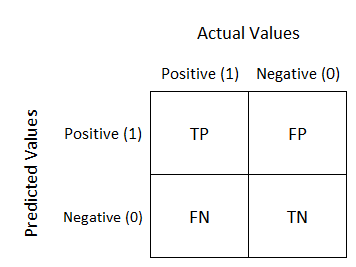

# LSTM

In [13]:
import torch.nn as nn
import torch

lstm = nn.LSTM(100, 200)
out, _ = lstm(torch.tensor(dataset['train'][0]['mean']).unsqueeze(1))

In [15]:
lstm = nn.LSTM(100, 200, 2, batch_first=True)
out, _ = lstm(torch.tensor(dataset['train'][0]['mean']).unsqueeze(1))

In [16]:
out.shape

torch.Size([100, 200])

# Task 3

Slice the output of the LSTM to get the last token’s output for every sample in the batch.

In [22]:
last_token_output = out[-1, :]

In [40]:
word_embedding = Word2Vec.load('/kaggle/working/w2v.model')

In [24]:
def word_to_index(example):
    indices = []
    for token in example['tokens']:
        if token in word_embedding.wv.key_to_index:
            indices.append(word_embedding.wv.key_to_index[token])
    return {'indices': indices}
dataset = dataset.map(word_to_index)

Map:   0%|          | 0/39908 [00:00<?, ? examples/s]

Map:   0%|          | 0/4956 [00:00<?, ? examples/s]

Map:   0%|          | 0/4963 [00:00<?, ? examples/s]

In [25]:
pad_vector = np.zeros(word_embedding.vector_size)
weights = np.vstack([word_embedding.wv.vectors, pad_vector])
vocab_size, embedding_size = weights.shape
pad_idx = vocab_size - 1

In [26]:
def pad_sequences(batch):
    indices = [torch.tensor(sample, dtype=torch.long) for sample in batch['indices']]
    indices = nn.utils.rnn.pad_sequence(indices, batch_first=True,padding_value=pad_idx)
    return {
        'indices': indices
    }

dataset = dataset.map(pad_sequences, batched=True,batch_size=None).with_format('torch')

Map:   0%|          | 0/39908 [00:00<?, ? examples/s]

Map:   0%|          | 0/4956 [00:00<?, ? examples/s]

Map:   0%|          | 0/4963 [00:00<?, ? examples/s]

In [27]:
import torch.nn.functional as F

class SentimentClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers):
        super(SentimentClassifierLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x, h0, c0):
        embeddings = self.embedding(x)
        out, _ = self.lstm(embeddings, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        out = F.sigmoid(out)
        return out.squeeze(1)

In [28]:
hidden_size = 128
num_layers = 2
model = SentimentClassifierLSTM(vocab_size=vocab_size, embedding_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers)
model.embedding.weight = nn.Parameter(torch.FloatTensor(weights))
model.embedding.weight.requires_grad = False

In [29]:
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

In [31]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 2048

def to_dataloader(dataset, split, shuffle):
    dataset = TensorDataset(dataset[split]['indices'], dataset[split]['sentiment'])
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataloader = to_dataloader(dataset, 'train', True)
test_dataloader = to_dataloader(dataset, 'test', False)
validation_dataloader = to_dataloader(dataset, 'validation', False)

In [36]:
def train_one_epoch(dataloader):
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device).float()

        h0 = torch.zeros(model.num_layers, inputs.size(0), model.hidden_size).to(device)
        c0 = torch.zeros(model.num_layers, inputs.size(0), model.hidden_size).to(device)

        outputs = model(inputs, h0, c0)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Task 4

Use the train one epoch to train the model on 20 epochs. Bonus: Evaluate the model on the validation set after each epoch and print the validation accuracy

In [37]:
def train_and_evaluate(epochs, train_dataloader, validation_dataloader):
    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            h0 = torch.zeros(model.num_layers, inputs.size(0), model.hidden_size).to(device)
            c0 = torch.zeros(model.num_layers, inputs.size(0), model.hidden_size).to(device)

            outputs = model(inputs, h0, c0)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            
        train_loss /= len(train_dataloader.dataset)
        
        # Validation
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validation_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).float()
                
                h0 = torch.zeros(model.num_layers, inputs.size(0), model.hidden_size).to(device)
                c0 = torch.zeros(model.num_layers, inputs.size(0), model.hidden_size).to(device)
                
                outputs = model(inputs, h0, c0)
                loss = criterion(outputs, labels)
                
                validation_loss += loss.item() * inputs.size(0)
                predicted = torch.round(outputs)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
        validation_loss /= len(validation_dataloader.dataset)
        validation_accuracy = correct / total
        
        print(f"Epoch {epoch}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Validation Loss: {validation_loss:.4f}, "
              f"Validation Accuracy: {validation_accuracy:.4f}")

# Train and evaluate the model
epochs = 20
train_and_evaluate(epochs, train_dataloader, validation_dataloader)

Epoch 1/20, Train Loss: 0.6828, Validation Loss: 0.6430, Validation Accuracy: 0.6495
Epoch 2/20, Train Loss: 0.6358, Validation Loss: 0.6071, Validation Accuracy: 0.6858
Epoch 3/20, Train Loss: 0.5850, Validation Loss: 0.5696, Validation Accuracy: 0.6992
Epoch 4/20, Train Loss: 0.5663, Validation Loss: 0.5636, Validation Accuracy: 0.7030
Epoch 5/20, Train Loss: 0.5596, Validation Loss: 0.5493, Validation Accuracy: 0.7151
Epoch 6/20, Train Loss: 0.5522, Validation Loss: 0.5489, Validation Accuracy: 0.7189
Epoch 7/20, Train Loss: 0.5488, Validation Loss: 0.5422, Validation Accuracy: 0.7195
Epoch 8/20, Train Loss: 0.5464, Validation Loss: 0.5501, Validation Accuracy: 0.7167
Epoch 9/20, Train Loss: 0.5428, Validation Loss: 0.5493, Validation Accuracy: 0.7218
Epoch 10/20, Train Loss: 0.5401, Validation Loss: 0.5409, Validation Accuracy: 0.7248
Epoch 11/20, Train Loss: 0.5382, Validation Loss: 0.5357, Validation Accuracy: 0.7294
Epoch 12/20, Train Loss: 0.5386, Validation Loss: 0.5430, Valid

# Task 5

 Evaluate the model on the test set using the accuracy and confusion matrix.

In [38]:
def evaluate_test_set(test_dataloader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            h0 = torch.zeros(model.num_layers, inputs.size(0), model.hidden_size).to(device)
            c0 = torch.zeros(model.num_layers, inputs.size(0), model.hidden_size).to(device)

            outputs = model(inputs, h0, c0)
            predicted = torch.round(outputs)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    accuracy = accuracy_score(true_labels, predictions)
    confusion_mat = confusion_matrix(true_labels, predictions)
    return accuracy, confusion_mat

# Evaluate the model on the test set
test_accuracy, test_confusion_matrix = evaluate_test_set(test_dataloader)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Confusion Matrix:")
print(test_confusion_matrix)

Test Accuracy: 0.7453
Confusion Matrix:
[[1968  600]
 [ 664 1731]]


# Task 6: 

Compare the performance of the model with the performance of the Average Vector model.

We can see that the accuracy increased from **67%** to **75%**, which indicates that the second model is better.

# Transformers

In [43]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('lyeonii/bert-mini')

In [44]:
tokenized_dataset = dataset.map(lambda x: tokenizer(x['text'],padding=True,return_tensors='pt'), batched=True, batch_size=None).with_format('torch')

tokenized_dataset = tokenized_dataset.rename_column('sentiment', 'labels')

Map:   0%|          | 0/4956 [00:00<?, ? examples/s]

In [45]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("lyeonii/bert-mini",num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at lyeonii/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="sentiment-analysis",
    num_train_epochs=3,
    per_device_train_batch_size=512,
    per_device_eval_batch_size=512,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"]
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.590800,0.499932
2,0.487000,0.463066
3,0.458600,0.458403


TrainOutput(global_step=234, training_loss=0.5121189182640141, metrics={'train_runtime': 106.0092, 'train_samples_per_second': 1129.374, 'train_steps_per_second': 2.207, 'total_flos': 370764118264320.0, 'train_loss': 0.5121189182640141, 'epoch': 3.0})

# Task 7

Use compute metrics in Trainer constructor, with evaluate package, to compute validation accuracy

In [47]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.439100,0.446786,0.793584
2,0.409300,0.440070,0.797215
3,0.405000,0.441439,0.798426


TrainOutput(global_step=234, training_loss=0.4178221857445872, metrics={'train_runtime': 106.0912, 'train_samples_per_second': 1128.501, 'train_steps_per_second': 2.206, 'total_flos': 370764118264320.0, 'train_loss': 0.4178221857445872, 'epoch': 3.0})

# Task 8

Evaluate the model on the test set using the accuracy and confusion matrix.

In [48]:
test_predictions = trainer.predict(tokenized_dataset["test"])
test_logits = test_predictions.predictions
test_labels = tokenized_dataset["test"]["labels"]

test_predictions = np.argmax(test_logits, axis=1)

test_accuracy = accuracy_score(test_labels, test_predictions)

test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Confusion Matrix:")
print(test_confusion_matrix)

Test Accuracy: 0.8066
Confusion Matrix:
[[2116  452]
 [ 508 1887]]


wandb: Network error (ReadTimeout), entering retry loop.


# Task 9: 

Compare the model with the previously trained models.

We can see that this model performed better than the previous 2 before, achieving accuracy of **81%**.